<a href="https://colab.research.google.com/github/BarnabasLim/Tensorflow/blob/main/TimeSeriesPredictionNotesDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [34]:
print("Step 1: create a data set")
#Step 1: create a data set
dataset = tf.data.Dataset.range(10)
# for val in dataset:
#    print(val.numpy())

print("Step 2: To just get chunks of five records, we'll set drop_reminder to true")
#Step 2: To just get chunks of five records, we'll set drop_reminder to true
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

print("Step 3: batch of 5")
#Step 3: batch of 5
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

print("Step 4: split into x's and y's or features and labels using flat_map")
#Step 4: split into x's and y's or features and labels using flat_map
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

print("Step 5: Shuffle the data to rearrange the data so as not to accidentally introduce a sequence bias")
#Step 5: Shuffle the data to rearrange the data so as not to accidentally introduce a sequence bias.
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

print("Step 6: batch size of two, our data gets batched into two x's and two y's at a time.")
#Step 6: batch size of two, our data gets batched into two x's and two y's at a time. 
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

Step 1: create a data set
Step 2: To just get chunks of five records, we'll set drop_reminder to true
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
Step 3: batch of 5
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]
Step 4: split into x's and y's or features and labels using flat_map
[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]
Step 5: Shuffle the data to rearrange the data so as not to accidentally introduce a sequence bias
[3 4 5 6] [7]
[0 1 2 3] [4]
[4 5 6 7] [8]
[2 3 4 5] [6]
[5 6 7 8] [9]
[1 2 3 4] [5]
Step 6: batch size of two, our data gets batched into two x's and two y's at a time.
x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [[8]
 [4]]
x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [[6]
 [9]]
x =  [[3 4 5 6]
 [1 2 3 4]]
y =  [[7]
 [5]]


In [35]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[5 6 7 8]
 [3 4 5 6]]
y =  [[9]
 [7]]
x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]


## __1. Generating Sequences using Python__<hr>
Adapted from Coursera Sequences, Time Series and Prediction
Week 1
Introduction to time series notebook

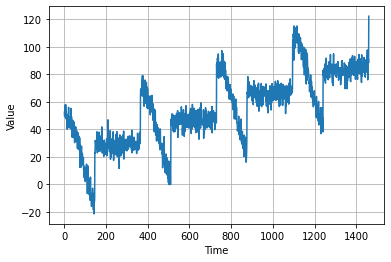

In [36]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plot_series(time, series, format="-", start=0, end=None)


## __2.Data Preprocessing (Windowing)__<hr>

2.1 Create Windowed Data Set<br>
2.2 Seperate into features (x) and labels (y)<br>
2.3 Shuffle data<br>
2.4 batch the data for use in training<br>

In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  #e.g.
  # window_size = 4
  # batch_size = 2
  # shuffle_buffer_size = 10

  dataset = tf.data.Dataset.from_tensor_slices(series)
  

  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # 0 1 2 3 4 
  # 1 2 3 4 5 
  # 2 3 4 5 6 
  # 3 4 5 6 7 
  # 4 5 6 7 8 
  # 5 6 7 8 9 

  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))  
  # [0 1 2 3 4]
  # [1 2 3 4 5]
  # [2 3 4 5 6]
  # [3 4 5 6 7]
  # [4 5 6 7 8]
  # [5 6 7 8 9]

  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # [0 1 2 3] [4]
  # [1 2 3 4] [5]
  # [2 3 4 5] [6]
  # [3 4 5 6] [7]
  # [4 5 6 7] [8]
  # [5 6 7 8] [9]

  dataset = dataset.batch(batch_size).prefetch(1)
  # x =  [[5 6 7 8]
  #       [0 1 2 3]]
  # y =  [[9]
  #       [4]]
  # x =  [[3 4 5 6]
  #       [1 2 3 4]]
  # y =  [[7]
  #       [5]]
  # x =  [[2 3 4 5]
  #       [4 5 6 7]]
  # y =  [[6]
  #       [8]]

  return dataset

In [38]:
#for preparing the data
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


## __3. Create model__<hr>

$$Y=W^{[1]}_{0}X_{0}+W^{[1]}_{1}X_{1}+W^{[1]}_{2}X_{2}+...+W^{[1]}_{19}X_{19}+b$$
Single dense layer containing 1 neuron.<br>
Each neuron input shape is window size<br>
<br>
Note: Dense layer is assigned to variable __"l0"__ so that it can be accessed later to study the weights that is generated. 


In [39]:
#Create model
#Single Dense layer l0, with 1 neuron and input shape is the window size
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

#Compile model with Loss:=MSE and Optimiser:=Sochastic Gradient Descent
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
#Fit the model 100 epoch
model.fit(dataset,epochs=100,verbose=0)


#Inspect Weights of the neuron with the get_weights() methods
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.04268675],
       [ 0.06469715],
       [-0.06411008],
       [ 0.01305999],
       [-0.02827406],
       [ 0.09257631],
       [-0.00902942],
       [ 0.01610674],
       [-0.08835539],
       [ 0.06409457],
       [-0.08476809],
       [ 0.07627675],
       [ 0.01810771],
       [-0.02652051],
       [ 0.03092149],
       [ 0.04407788],
       [ 0.0503578 ],
       [ 0.10759038],
       [ 0.3216747 ],
       [ 0.43955532]], dtype=float32), array([0.01186149], dtype=float32)]


##__4. Generate prediction__ <hr>
Generate Prediction and store it in an list.<br>
Note: prediction can only be done from __"start time"__ unitl __"end time-window size"__ 

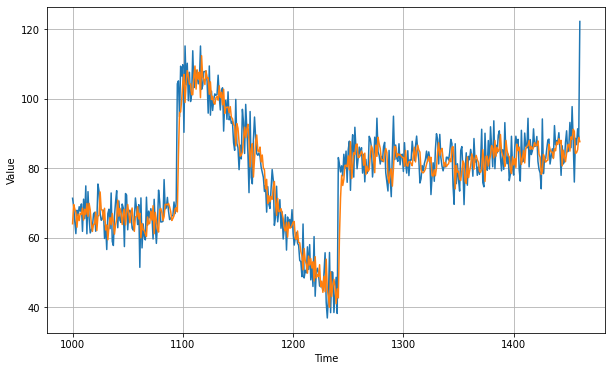

In [40]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.06878

##__Step 1: Generating Sequences__


##__Step 2: Splitting training and validation data__

In [42]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

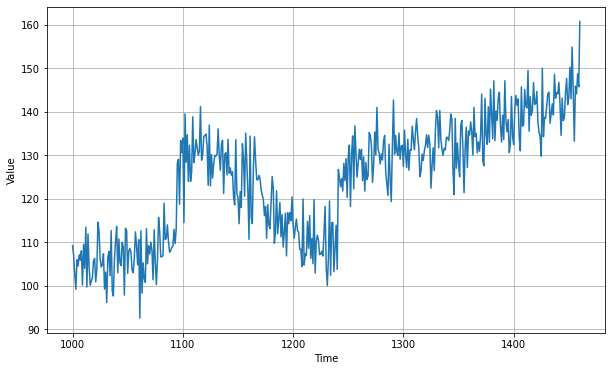

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

##__Step 3: Data Preprocessing (Windowing)__

##__Step 4: Create Model (Windowing)__
<hr>
4.1 2 dense layer with 10 neuron each<br>
4.2 compile model with loss:=MSE and Optimiser:=Sochastic Gradient Descent<br>
4.3 fit model

In [55]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


##__Step 5: Generate Prediction__

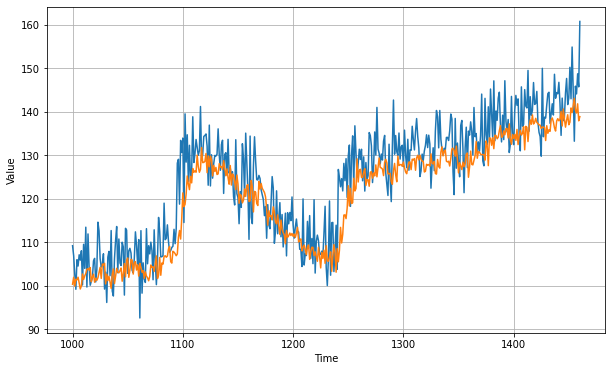

In [45]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

##_Step 6: Evaluate Prediction_

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.520233

##__Step 7: Hyper Parameter Tuning__


###Step 7.1 use callbacks to change learning rate at each epoch

In [47]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

###Step 7.2 plot Loss against learning rate
Select lowest point of the curve where it's still relatively stable

(1e-08, 0.001, 0.0, 300.0)

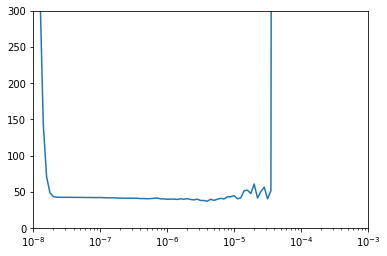

In [48]:
#Note Learning Rate lrs increases as the epoch increases
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

##__Step 8: Retrain model with new selected learning Rate__

In [49]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

### Step 8.1 plot loss against epoch

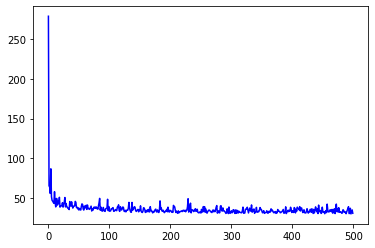

In [50]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

### Step 8.2 plot loss against epoch removing first 10 epoch

[57.86754608154297, 44.19514465332031, 38.677738189697266, 49.33289337158203, 48.885704040527344, 41.00214767456055, 45.675418853759766, 43.59108352661133, 50.812049865722656, 38.389556884765625, 39.86640167236328, 39.83877944946289, 40.29414749145508, 43.92168426513672, 38.40058898925781, 42.32756423950195, 44.73551559448242, 50.557735443115234, 38.662227630615234, 43.05555725097656, 38.790740966796875, 38.37919998168945, 36.78947067260742, 36.64002227783203, 35.3307991027832, 45.47217559814453, 40.38637924194336, 39.64707565307617, 45.109825134277344, 40.45848846435547, 37.1957893371582, 39.328243255615234, 39.86412811279297, 39.79594421386719, 45.646610260009766, 44.48889923095703, 37.92554473876953, 38.20783996582031, 36.22561264038086, 37.48862838745117, 34.71171569824219, 36.74848937988281, 35.60245895385742, 34.71107482910156, 39.385475158691406, 42.55097198486328, 41.73221969604492, 36.055885314941406, 34.69948196411133, 39.78468322753906, 37.41460037231445, 37.61699676513672, 

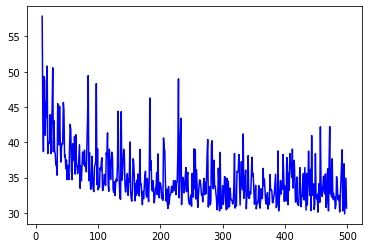

In [51]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

## __Step 9: Generate forcast__

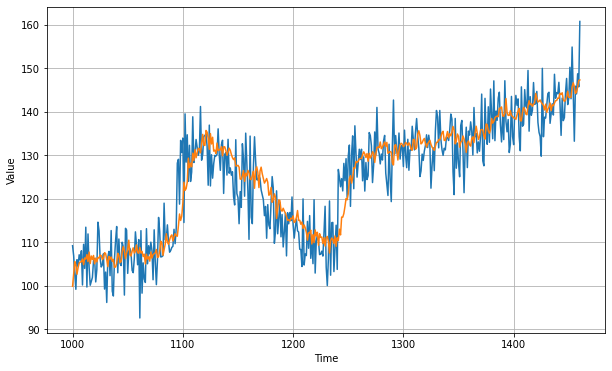

In [52]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## __Step 10: Evaluate Model__

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6827908